<a href="https://colab.research.google.com/github/luiizsps/MachineLearning/blob/main/spam_detection_naiveBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [65]:
# download necessary nltk resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ness/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/ness/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ness/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ness/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ness/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [66]:
# load dataset
path = "datasets/completeSpamAssassin.csv"
df = pd.read_csv(path)
df.head(10)

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1
5,5,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,1
6,6,Help wanted. We are a 14 year old fortune 500...,1
7,7,ReliaQuote - Save Up To 70% On Life Insurance\...,1
8,8,TIRED OF THE BULL OUT THERE?\nWant To Stop Los...,1
9,9,"Dear ricardo1 ,\nCOST EFFECTIVE Direct Email A...",1


In [67]:
# show number of emails
df.shape[0]

6046

In [68]:
df['Label'].value_counts()

Label
0    4150
1    1896
Name: count, dtype: int64

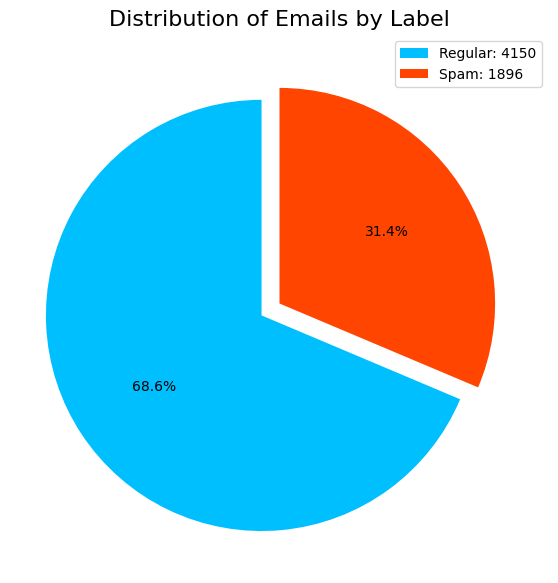

In [69]:
# show distribution of emails by label
label = df['Label'].value_counts()
counts = [label[0], label[1]]

x_plot = ['0','1']
labels = ['Regular', 'Spam']
explodir = (0.1, 0)
cores = ['deepskyblue', 'orangered']

fig, ax = plt.subplots(figsize=(7,7))
ax.pie(counts, colors=cores, explode=explodir, autopct='%1.1f%%', shadow=False, startangle=90)

legend_labels = ['{}: {}'.format(classe, valor) for classe, valor in zip(labels, counts)]
ax.legend(legend_labels, loc='upper right')
ax.set_title('Distribution of Emails by Label', fontsize=16)

plt.show()

In [70]:
# using regex to remove special characters from the 'Body' column
def remove_special_char(text):
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    return clean_text

df['Body'] = [remove_special_char(str(text).lower()) for text in df['Body']]
df['Body'].head(10)

0    \nsave up to 70  on life insurance \nwhy spend...
1    1  fight the risk of cancer \nhttp   www adcli...
2    1  fight the risk of cancer \nhttp   www adcli...
3                                                  ...
4    i thought you might like these \n1  slim down ...
5    a powerhouse gifting program you don t want to...
6    help wanted   we are a 14 year old fortune 500...
7    reliaquote   save up to 70  on life insurance\...
8    tired of the bull out there \nwant to stop los...
9    dear ricardo1  \ncost effective direct email a...
Name: Body, dtype: object

In [71]:
# transform emails into tokens
df['Body'] = df['Body'].astype(str).apply(word_tokenize)
df['Body'].head(10)

0    [save, up, to, 70, on, life, insurance, why, s...
1    [1, fight, the, risk, of, cancer, http, www, a...
2    [1, fight, the, risk, of, cancer, http, www, a...
3    [adult, club, offers, free, membership, instan...
4    [i, thought, you, might, like, these, 1, slim,...
5    [a, powerhouse, gifting, program, you, don, t,...
6    [help, wanted, we, are, a, 14, year, old, fort...
7    [reliaquote, save, up, to, 70, on, life, insur...
8    [tired, of, the, bull, out, there, want, to, s...
9    [dear, ricardo1, cost, effective, direct, emai...
Name: Body, dtype: object

In [72]:
# find most frequent words
def list_most_frequent_words(df):
    all_words = [word for word_list in df['Body'] for word in word_list]
    word_count = Counter(all_words)
    most_regular_words = word_count.most_common(20)
    return list(zip(*most_regular_words))

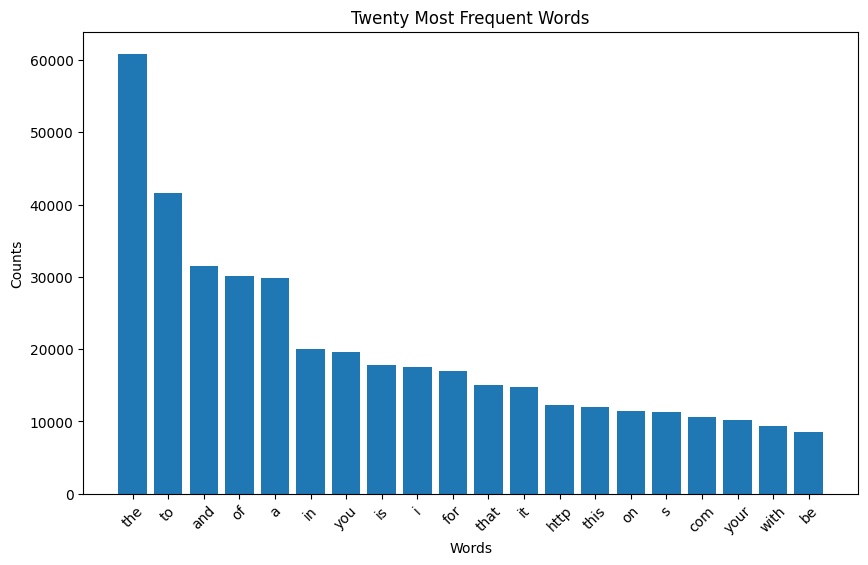

In [73]:
words, counts = list_most_frequent_words(df)

plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Twenty Most Frequent Words')
plt.xticks(rotation=45)
plt.show()

In [74]:
# remove stop words
stop_words = set(stopwords.words('english'))

df['Body'] = [[word for word in tokens_list if word not in stop_words] for tokens_list in df['Body']]
df['Body'].head(10)

0    [save, 70, life, insurance, spend, life, quote...
1    [1, fight, risk, cancer, http, www, adclick, w...
2    [1, fight, risk, cancer, http, www, adclick, w...
3    [adult, club, offers, free, membership, instan...
4    [thought, might, like, 1, slim, guaranteed, lo...
5    [powerhouse, gifting, program, want, miss, get...
6    [help, wanted, 14, year, old, fortune, 500, co...
7    [reliaquote, save, 70, life, insurance, life, ...
8    [tired, bull, want, stop, losing, money, want,...
9    [dear, ricardo1, cost, effective, direct, emai...
Name: Body, dtype: object

In [75]:
# removing numbers
df['Body'] = [[word for word in row if not re.search(r'\d', word)] for row in df['Body']]

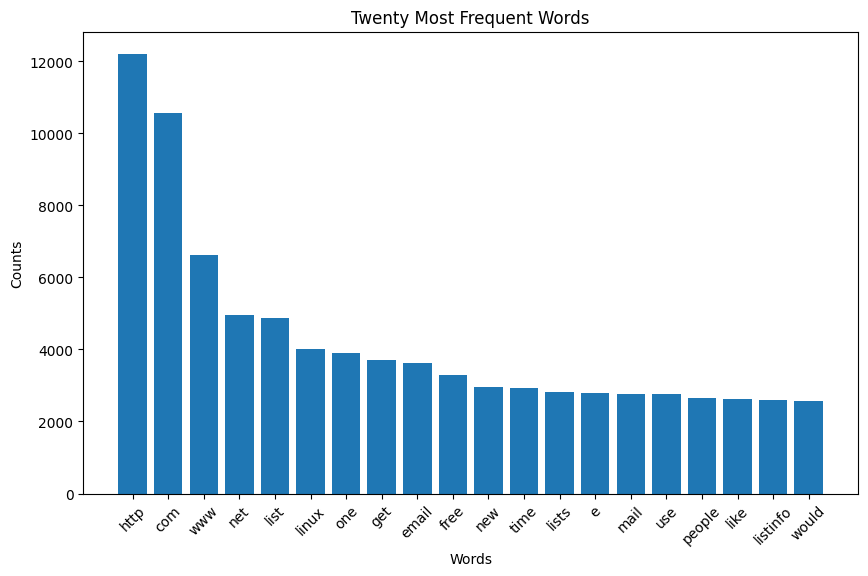

In [76]:
words, counts = list_most_frequent_words(df)

plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Twenty Most Frequent Words')
plt.xticks(rotation=45)
plt.show()

In [77]:
all_words = [word for tokens_list in df['Body'] for word in tokens_list]
word_counts = Counter(all_words)

threshold = 2

# find rare words
rare_words = set([word for word, count in word_counts.items() if count <= threshold])

# remove rare words from the tokens
def remove_rare_words(tokens_list, rare_words_set):
    return [word for word in tokens_list if word not in rare_words_set]

#apply the function to the 'Body' column
df['Body'] = df['Body'].apply(lambda tokens: remove_rare_words(tokens, rare_words))
df['Body'].head(10)

0    [save, life, insurance, spend, life, quote, sa...
1    [fight, risk, cancer, http, www, adclick, ws, ...
2    [fight, risk, cancer, http, www, adclick, ws, ...
3    [adult, club, offers, free, membership, instan...
4    [thought, might, like, slim, guaranteed, lose,...
5    [powerhouse, gifting, program, want, miss, get...
6    [help, wanted, year, old, fortune, company, gr...
7    [reliaquote, save, life, insurance, life, chan...
8    [tired, bull, want, stop, losing, money, want,...
9    [dear, cost, effective, direct, email, adverti...
Name: Body, dtype: object

In [78]:
# normalizing data using lemmatization
nlp = spacy.load("en_core_web_sm")
df['Body'] = [[token.lemma_ for token in nlp(" ".join(linha))] for linha in df['Body']]
df['Body'].head(10)

0    [save, life, insurance, spend, life, quote, sa...
1    [fight, risk, cancer, http, www, adclick, ws, ...
2    [fight, risk, cancer, http, www, adclick, ws, ...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarantee, lose, ...
5    [powerhouse, gift, program, want, miss, get, f...
6    [help, want, year, old, fortune, company, grow...
7    [reliaquote, save, life, insurance, life, chan...
8    [tired, bull, want, stop, lose, money, want, r...
9    [dear, cost, effective, direct, email, adverti...
Name: Body, dtype: object

In [79]:
# word embedding
sentences = [" ".join(words) for words in df['Body']]

vectorizer = CountVectorizer(binary=True)
X_data = vectorizer.fit_transform(sentences)

# saving unique words
unique_words = vectorizer.get_feature_names_out()

X_data.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(6046, 18340))

In [ ]:
Y_data = df['Label']
# split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=5, stratify=Y_data)

# train model Bernoulli NaiveBayes
model = BernoulliNB()
model.fit(X_train, y_train)

# evaluate model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)


In [81]:
results = {
    'accuracy': [accuracy],
    'precision': [precision],
    'recall': [recall],
    'f1-score': [f1_score]
}

print(results)

df_res = pd.DataFrame(results)
df_res.to_csv("resultados.csv", index=False)

{'accuracy': [0.9244762954796031], 'precision': [0.984304932735426], 'recall': [0.7715289982425307], 'f1-score': [0.865024630541872]}


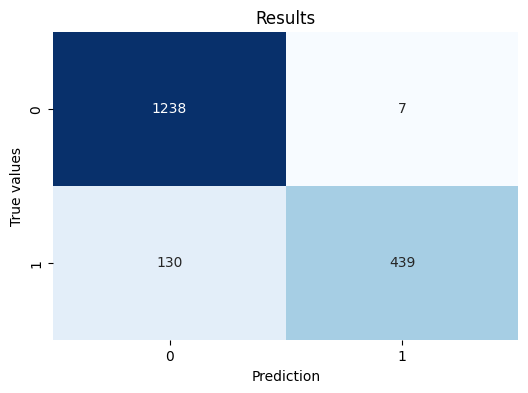

In [82]:
# show results as confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Prediction')
plt.ylabel('True values')
plt.title('Results')
plt.show()

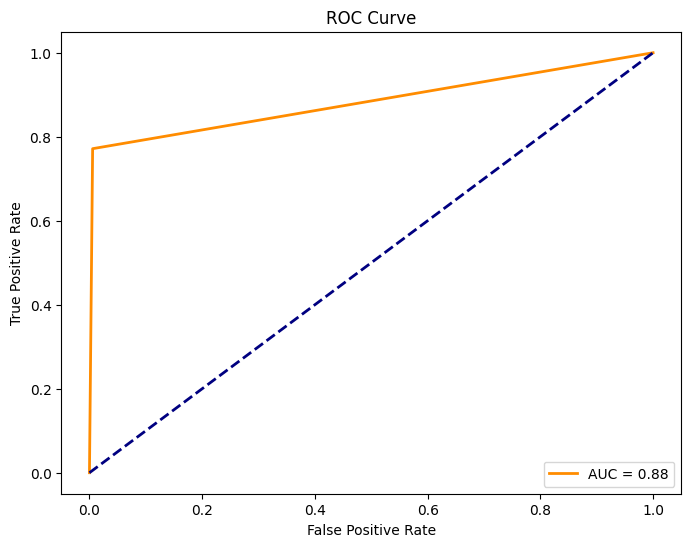

In [ ]:
# calc roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()